# Contents:
 1. Read and sparse X-ray/neutron diffraction refinement files produced by Fullprof
 2. Plot the data in the PRF file: data, calculation and their difference
 3. Read and load the neutron diffraction data from the DMC instrument in PSI


# Read and sparse X-ray/neutron diffraction refinement files produced by Fullprof

In [1]:
##################################################################
# Three functions for import and plot PRF file from fullprof #
##################################################################
# 
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib ipympl
plt.rcParams["font.family"] = 'arial'
#plt.rcParams['figure.figsize'] = 5, 10

### defind the prf object
class prf(object):
    def __init__(self, pname, abc, abg, sg, wavelen, nopeaks, the2, yobs, ycal, yo_c, bragg, bpos):
        self.phasename = pname
        self.abc, self.abg, self.sg, self.wavelen, self.nopeaks   =   abc, abg, sg, wavelen, nopeaks
        self.the2, self.yobs, self.ycal, self.yo_c, self.bragg, self.bpos   =   the2, yobs, ycal, yo_c, bragg, bpos

### read function        
def read_prf(file):
    f=open(file, 'rU').readlines()
    dataStartAt = 0
    # read the headerlines: sometime the prf file has different no. of lines of header; 
    # and determine No. of peaks
    for row, line in enumerate(f):
        line = line.rstrip('\n').split()
        if row == 0:
            phasename = line[0]
            idx = line.index('CELL:')
            abc, abg = map(np.float,line[idx+1:idx+4]), map(np.float,line[idx+4:idx+7])  
            sg = ''.join(line[line.index('SPGR:')+1:]); 
        elif row == 1:
            noposs = np.int(line[1])
            wavelen = np.float(line[2])
        elif line[0]=='2Theta':
            dataStartAt = row+1
            print('dataStartAt', dataStartAt,'th line')
        elif row>10 and len(line)== 5:
            nopeaks = row - dataStartAt
            print('no. of peak', nopeaks)
            break
    the2 = np.zeros([noposs,1],dtype=float)
    bragg = np.zeros([nopeaks,1],dtype=float)
    yobs, ycal, yo_c =np.zeros_like(the2), np.zeros_like(the2), np.zeros_like(the2)
    bpos = np.zeros_like(bragg)
    print("Phase Name ", phasename,"\n", "No of data points", noposs, the2.shape,bragg.shape)
    idx = 0
    # read data : 5 columns （2theta,Yobs,Ycal,Yo-Yc,bragg, braggY）
    for line in f[dataStartAt:]:
        line=line.rstrip('\n').split()
        if len(line)>5: # just use try except for fun!!!
            try:
                the2[idx], yobs[idx], ycal[idx], yo_c[idx], _, bragg[idx], bpos[idx] =np.array(list(map(np.float,line[0:7])))
                idx += 1
            except:
                print(line[0:7])
        else:
            the2[idx], yobs[idx], ycal[idx], yo_c[idx] = map(np.float,line[0:4]) 
            idx += 1
    return prf(phasename, abc, abg, sg, wavelen, nopeaks,
               the2.ravel(), yobs.ravel(), ycal.ravel(), yo_c.ravel(), bragg.ravel(), bpos.ravel());

###### plot function
# def the autocale_y fun for setting xlim then autoscale Ylim (not used)
def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""
    import numpy as np
    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top
            
    ax.set_ylim(bot,top)


def plot_prf(prf,**kwargs):
    #plot_prf(prf, symblesize, linewidth, axefont, scale, shiftDeff, shiftBragg):
    """Reference Values:
    plot_prf(prf,[4.2,86])
    plot_prf(prf, 4, 1, 14, 1.1, 0, 0)
    """ 
    figsize=(5.5,4); xlim=None; ylim=None; yscale=1.05; dyshift=0.1; bshift=0.05; legendcol=1
    inset=False; infigsize =[0.5, 0.5, 0.2, 0.2]; inxlim =None; inylim=None; # inset figsize [left, bottom, width, height]
    labelfont=14; ticksize=12; infont=12; savepath=None # if not saved here, the fig can be called and saved later
    for kw in kwargs:
        if kw == "figsize": figsize = kwargs[kw]
        elif kw == "xlim": xlim = kwargs[kw]
        elif kw == "ylim": ylim = kwargs[kw]
        elif kw == "yscale": yscale = kwargs[kw]
        elif kw == "dyshift": dyshift = kwargs[kw]
        elif kw == "bshift": bshift = kwargs[kw]
        elif kw == "legendcol": legendcol = kwargs[kw]
        elif kw == "inset": inset = kwargs[kw]
        elif kw == "infigsize": inset=True; infigsize = kwargs[kw]
        elif kw == "inxlim": inset=True; inxlim = kwargs[kw]
        elif kw == "inylim": inset=True; inylim = kwargs[kw]
        elif kw == "labelfont": labelfont = kwargs[kw]
        elif kw == "ticksize": ticksize = kwargs[kw]
        elif kw == "infont": infont = kwargs[kw]
        elif kw == "savepath": savepath = kwargs[kw]
    # transfer data
    ymax = np.max(prf.yobs)*yscale # for scaling the data small than 1
    the2,yobs,ycal,yo_c,bragg,ybragg = prf.the2, prf.yobs/ymax, prf.ycal/ymax, prf.yo_c/ymax+dyshift,\
                                       prf.bragg, prf.bpos/ymax+bshift   
    # main fig plot
    fig = plt.figure('fig_prf',figsize=figsize)
    ax = fig.add_subplot(111, autoscale_on=True)
    ax.plot(the2, yobs, 'o', mec = 'red', mfc='white', ms='4', label="Yobs",  rasterized=False)
    ax.plot(the2, ycal, c='black', label="Ycal",  rasterized=False)
    ax.plot(the2, yo_c, c='blue',label="Yobs-Ycal", rasterized=False)  
    print(the2,yo_c)
    ax.plot(bragg, ybragg, '|', ms='6', c='green',label="Bragg Pos." )  
    
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    
    leg = ax.legend(loc='best',numpoints=1,ncol=legendcol,frameon=True,framealpha=1,fontsize=12,fancybox=True,shadow=False)
    leg.get_frame().set_edgecolor('w') 
    ax.set_xlabel(r'2Theta (degree)',size=labelfont)#,labelpad=0)
    ax.set_ylabel('Intensity (a.u.)',size=labelfont)#,labelpad=0)    
    #plt.xlabel(r"2Theta (degree)",size=labelfont)
    #plt.ylabel('Intensity (a.u.)',size=labelfont)
    #ax.yaxis.labelpad = 5 # ylable position
    plt.minorticks_on()
    plt.xticks(color='k', size=ticksize)
    plt.yticks(color='k', size=ticksize)
    
    # Plot zoomed inset
    if inset==True:
        left, bottom, width, height = infigsize
        ax2 = fig.add_axes([left, bottom, width, height],frame_on=True)#, animated=True)
        ax2.autoscale(enable=True, axis='y', tight=None)
        # ax2.autoscale_view(True,True,False) # it refers to all the data ploted (we can just plot part of the data)
        # just plot the needed data to enable autoscale Y
        if inxlim != None:
            mask = (the2 >= inxlim[0]) & (the2 <= inxlim[1])
            ax2.plot(the2[mask], yobs[mask], 'o', mec = 'red', mfc='white', ms='4', label="Yobs", rasterized=True)
            ax2.plot(the2[mask], ycal[mask], c='black',label="Ycal", rasterized=True)
        else:
            ax2.plot(the2, yobs, 'o', mec = 'red', mfc='white', ms='4', label="Yobs", rasterized=True)
            ax2.plot(the2, ycal, c='black',label="Ycal",  rasterized=True)            
        if inylim != None: plt.ylim(inylim)
        plt.yticks(visible=False)
        #plt.minorticks_on()
    if savepath != None:
        print("Fig saved ", savepath)
        fig.savefig(savepath, bbox_inches="tight", verbose=True)
    #plt.show()
    
######## this part is use zoom fun, not good: cannot choose the size of the zoomed fig 
#(because it depend on zoomed region and zoom scale) 
#     if inset==True:
#         from matplotlib.ticker import MaxNLocator
#         from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#         from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
#         axins = zoomed_inset_axes(ax, 15, loc=10,
#                                   bbox_to_anchor=(0.6, 0.5), bbox_transform=ax.figure.transFigure)
#         axins.plot(the2, yobs, 'o', mec = 'red', mfc='white', ms='4', label="Yobs")
#         axins.plot(the2, ycal, c='black',label="Ycal")      
#         axins.axis([70, 75, 0, 0.015])
#         #axins.invert_yaxis() # get the ticks point out
#         #axins.xaxis.tick_top()
#         plt.xticks(visible=False)
#         plt.yticks(visible=False)
#         mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5",zorder = 3)
#         axins.xaxis.set_major_locator(MaxNLocator(nbins=1, prune='lower'))

# Plot the data in the PRF file: data, calculation and their difference

In [2]:
# Nd2Zr2O7 Fullprof
fpath1 = 'D:/1_XRD/1 MSbeamline_July2014/Nd2Zr2O7/NZO5K.prf'
nzo = read_prf(fpath1)
print(nzo.phasename,nzo.abc, nzo.abg, nzo.sg, nzo.nopeaks,nzo.wavelen)#,nzo.the2

dataStartAt 5 th line
no. of peak 756
Phase Name  NZO5K 
 No of data points 23787 (23787, 1) (756, 1)
NZO5K <map object at 0x000001B281E72BA8> <map object at 0x000001B281E72CF8> Fd-3m 756 0.49573


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 'U' mode is deprecated


[ 0.3708  0.3744  0.378  ... 85.9932 85.9968 86.0004] [-0.14760802 -0.14760802 -0.14760802 ... -0.14727606 -0.14721085
 -0.14741833]


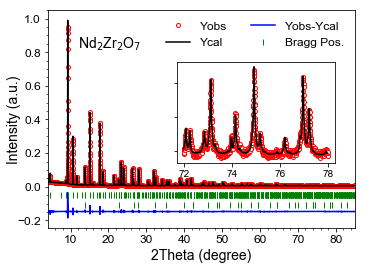

In [3]:
# % matplotlib notebook
plot_prf(nzo,xlim=[4,85],bshift=-0.05,dshift=0.0,
         inset=True,infigsize=[0.45,0.35,0.4,0.35],inxlim=[72,78], infont=12, legendcol=2)
ax = plt.gcf().get_axes()[0]
ax.text(12, 0.85,r'Nd$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position

# Read and load the neutron diffraction data from the DMC instrument in PSI

In [7]:
################################### Read the dmc data ################
########### define the function to read ND DMC data file and the binning fun. #########
#################################################################
#%matplotlib qt
import os
import numpy as np
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!

def read_dmc(fpath):
    with open(fpath, 'rU') as f:
        i, ii = 0, 0
        for line in f:     
            if i==0 or i==1:
                line = line.rstrip('\n').split()
                print("The data is",'\n',line)
                i+=1
            elif i==2:          ##### Gernerate 2theta from inf. in the 3rd line
                line = line.rstrip('\n').split()
                spts,step,fpts = map(np.float,[line[0],line[1],line[2]])
                numpts = int((fpts-spts)/step+1) # why 1314 is 1313 for np
                print('The 2theta is',spts,step,fpts,numpts)
                diffdata = np.zeros((numpts,3))
                print('The data shape is',diffdata.shape)
                diffdata[:,0] = np.linspace(spts,fpts,num=numpts,endpoint=True)
                i+=1
            else:              ##### Now read the intensity and error
                if ii<numpts:
                    line = line.rstrip('\n').split()
                    apd = len(line)
                    try:
                        diffdata[ii:ii+apd,1]= map(np.float,line)
                        ii+=apd
                    except:
                        print('Error',ii, line)
                        break
                else:
                    if ii<2*numpts:
                        line = line.rstrip('\n').split()
                        apd = len(line)
                        diffdata[ii-numpts:ii-numpts+apd,2]= map(np.float,line)
                        ii+=apd
    return diffdata

#This binning with the error calculated in this way is not good if the input data has too few point. 
# For example, if nbins=size(x), error will be 0.
def lin_binning(x,y,nbins): #input: data x,y ; No of points you want nbins  
    #nbins+=1     
    x = x[~np.isnan(x)] # remove nan from the data
    y = y[~np.isnan(y)]
    
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    meany= np.histogram(x, bins=nbins, weights=y) [0]/ n
    meany2= np.histogram(x, bins=nbins, weights=y*y)[0] / n
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return meanx,meany,std_y #putput: nbins rows, 3 col

path='D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Gd2Zr2O7/'
fname = os.path.join(path,'Gd_2k_1.dat')
path='D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Nd2Zr2O7/'
fname = os.path.join(path,'2.45_100mk.dat')
data1=read_dmc(fname)
print(data1,fname.replace('.dat','_colm.dat'))
#np.savetxt(fname.replace('.dat','_colm.dat'),data1)

The data is 
 ['DMC,', 'Nd2Zr2O7', '2.45A', '100mK']
The data is 
 ['lambda=', '2.46087,', 'T=', '0.076,', 'dT=', '0.009,', "Date='2014-09-10", "05:49:42'"]
The 2theta is 11.0 0.1 92.7 818
The data shape is (818, 3)
Error 0 ['10024.', '9921.', '9866.', '9977.', '9742.', '9555.', '9466.', '9604.', '9628.', '9621.']
[[11.   0.   0. ]
 [11.1  0.   0. ]
 [11.2  0.   0. ]
 ...
 [92.5  0.   0. ]
 [92.6  0.   0. ]
 [92.7  0.   0. ]] D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Nd2Zr2O7/2.45_100mk_colm.dat


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 'U' mode is deprecated
  # Remove the CWD from sys.path while we load stuff.


(2L, 3L)


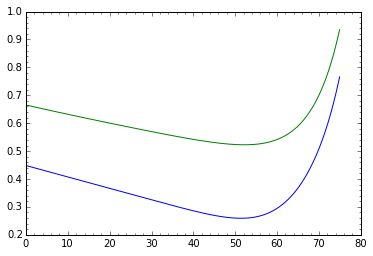

In [15]:
# plot the FWHM function for Fullprof and Topas
% matplotlib inline
def fwhm(uvw, th):
    width = uvw[0]*np.tan(th/180.*np.pi)**2+uvw[1]*np.tan(th/180.*np.pi)+uvw[2]
    return width**0.5
uvw = np.array([[0.085371, -0.213767, 0.201037],
                [0.102, -0.26290, 0.44253]])
print uvw.shape
th = np.linspace(0.0,150.,num=1500, endpoint=False)/2
width = fwhm(uvw[0,:],th)
width1 = fwhm(uvw[1,:],th)
plt.plot(th, width, th, width1)
plt.minorticks_on()
plt.show()